### University of Washington: Machine Learning and Statistics 

# Lecture 5:  Gaussian Processes

Andrew Connolly and Stephen Portillo

##### Resources for this notebook include:
- [Textbook](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) Chapter 8. 
- [astroML website](https://www.astroml.org/index.html)

This notebook is developed based on material from A. Connolly, Z. Ivezic, M. Juric, S. Portillo, G. Richards, B. Sipocz, J. VanderPlas, D. Hogg, Killian Weinberger and many others.

The notebook and assoociated material are available from [github](https://github.com/uw-astro/astr-598a-win22).

Make sure you are using the latest version of astroML, George and Statsmodels
> pip install --pre -U astroml

> pip install george

> pip install statsmodels

In [11]:
pip install jax

Note: you may need to restart the kernel to use updated packages.


<a id='toc'></a>

## This notebook includes:

[Gaussian Processes: physical intuition](#physical) 

[Gaussian Processes: mathematically](#math)

[Gaussian Processes: kernels](#kernels)
 
[Prediction with Gaussian Processes](#prediction)

[Building more complex models and kernels](#complex) 

## Gaussian Processes

##### The bible for Gaussian Processes is ["Gaussian Processes for Machine Learning"](http://www.gaussianprocess.org/gpml/chapters/) by Carl Rasmussen and Christopher Williams

Largely used in regression problems. Some of the major characteristics of GPs are
- interpretive
- provide uncertainty prediction
- slow (some advances for 1 and 2D data see [Celerite2](https://github.com/exoplanet-dev/celerite2))

Our goal is to predict $f(x)$ from the data. We can assume that  $f(x)$  is a random variable following a Normal distribution with $N(\mu(x), \sigma^2(x))$, where $\mu(x)$ is the *predictive mean* and $\sigma^2(x)$ is the *predictive variance*

To do this in a data driven manner relies on knowning (or learing) the kernel or correlation between data points. 

#### Gaussian Processes: Physical Intuition <a id='physical'></a>
[Go to top](#toc)

In our previous approaches for regression we wanted to find the probability of $P(y'|x', D, \theta)$ with $x'$ the point we want to evaluate, $\theta$ the parameters of the model, $D$ the training data. What if we wanted to find $P(y'|x',D)$ without relying on a model. How? 

We could marginalize over the model parameters. From Bayes,

$$P(y'|x',D) = \int_\theta P(y'|x',\theta) P(\theta|D) d\theta$$

$P(y'|x',\theta)$ can be expressed as a Normal distribution

$P(\theta|D)=P(D|\theta)P(\theta)$ which can be expressed as Normal distributions 


So $P(y'|x',D)$ is a Normal distribution (e.g. see conjugate priors)

Assume $P(y'|x',D) \sim N(\mu, \Sigma)$

<center><img width=50%,  src="figures/gaussian.png"></center>

One of the key points to GPs is that the input and predicted values will be correlated

If $y_{train}$ is large then $y'$ will be large

If $y_{train}$ is small then $y'$ will be small

How closely they track one another depends on the values in $\Sigma$ (and in particular the off diagonal elements).

##### Exercise: imagine 3 points along a light curve. One $y_0$ at time $t=0$, one with $y_1$ at time $t=1$ and another with $y_2$ at $t=100$. Write down what the correlation should be between these points in terms of the covariance matrix.

$$\mathbf{K} = \left(\begin{array}{cccc}
 - & -  & -   \\
 - & -  & -   \\
 - & -  & -   \\
\end{array}\right)$$

This is a positive definite correlation/covariance matrix -> a kernel

#### Gaussian Processes: Mathematically  <a id='math'></a>
[Go to top](#toc)

Data $x,y,dy$ are represented as a Gaussian Random Process. 

A random process is a function $f()$ where
- at location x, f(x) is a random variable
- $f(x_i)$ and $f(x_j)$ are correlated
- correlation strength is given by a kernel 

Random variable: variable drawn from a Normal with mean $\mu$ and variance $\sigma^2$

Random process (infinite random variables): characterized by the mean *function* $\mu(x)$ and covariance K=$\sigma^2(x_i, x_j)$. With $K$ the covariance or kernel function. At this point most texts wax lyrical about the idea of infinite random variables.

Therefore for a single point $x'$, $f(x')$ follows a Normal distribution. For a set of points $(x_0, x_1, \cdots)$, $f() = (f(x_0), f(x_1), \cdots)$ follows a multivariate Normal distribution.

$$\mathbf{f()} \sim N\left(\left(\begin{array}{c}
\mu(x_0) \\
\mu(x_1) \\
. \\
. \\
\mu(x_0) \\
\end{array}\right), 
\sigma^2 \left(\begin{array}{ccc}
K(x_0,x_0) & K(x_0,x_1) & \cdots  \\
K(x_1,x_0) & K(x_1,x_1) & \cdots  \\
. & . & \cdots \\
. & . & \cdots \\
\end{array}\right)\right)$$

We can now infer the most likely $\mu(x)$, $K(x_i, x_j)$, $\sigma$ that will produce the observed vales (i.e. the observed y's are a random draw from this multivariate Normal distribution).

We learn $\mu(x)$, $K(x_i, x_j)$, $\sigma$ with maximum likelihood estimation and then can predict $y'$ given $x'$. For most implementations we **learn the hyperparameters** associated with the kernel

K is symmetric and postive definite and often assumed to be stationary (only depends on distance)

In multiple dimensions (M),
$K(x_i, x_j) = \prod_{k=1}^{M} K(x_i^k, x_j^k)$
which means that the kernel is separable - we multiple 1 D kernels

#### Common Kernels   <a id='kernels'></a>
[Go to top](#toc)

<center><img width=50%,  src="figures/Squared-exponential-Matern-kernel.png"></center>
Credit:Florian M. Heckmeier


When the bandwith is large, predicted values at large distances are highly correlated. When the bandwith is small, predicted values at large distances are weakly correlated.  Many kernels are designed so that for large distances the predicted value tends to the mean (or zero).

As we learn the hyper parameters for the kernel, sorting by bandwidth (large to small) enables us to determine which features in a distribution are important (i.e. the ones with a small bandwidth) - relates to dimensionality reduction.


##### exponential

$$k(x_i, x_j) = \exp(-\theta|x_i - x_j|)$$

##### squared exponential

$$k(x_i, x_j) = \exp(-\theta(x_i - x_j)^2)$$

##### matern

$$k(x_i, x_j) =  \frac{1}{\Gamma(\nu)2^{\nu-1}}\Bigg(
\frac{\sqrt{2\nu}}{l} d(x_i , x_j )
\Bigg)^\nu K_\nu\Bigg(
\frac{\sqrt{2\nu}}{l} d(x_i , x_j )\Bigg)$$

where $d(\cdot,\cdot)$ is the Euclidean distance,
$K_{\nu}(\cdot)$ is a modified Bessel function and
$\Gamma(\cdot)$ is the gamma function.

#### Prediction with a Gaussian Process    <a id='prediction'></a>
[Go to top](#toc)

Given the training data we have a large multivariate Normal distribution

$P(y_0, y_1,..y_N|x_0, x_1,..x_N) \sim N()$

we want to predict $y'$ which is not a deterministic value but a random variable following a Normal distribution. We want,

$$ \left(\begin{array}{c}
y \\
y'
\end{array}\right)
\sim N \left( \mu, \sigma^2 \left(\begin{array}{cc}
K & k'  \\
k'^T & k'' 
\end{array}\right)\right) $$

where $K$ is the correlation matrix from the data, $k'$ is a correlation vector between the test (evaluated point) and training data, and  $k''$ variance of the test point (can be normalized to unity).

$$k' =  \left(\begin{array}{c}
K(x',x_0)  \\
K(x',x_1) \\
K(x',x_2) \\
. \\
. 
\end{array}\right)$$

this is essentially saying that we want  $P(y' | y_0, y_1,..y_N,x_0, x_1,..x_N, x')$ which is y' given x', conditional on $y_0, y_1,..y_N,x_0, x_1,..x_N$

We can derive $P(y'|y)$ which describes how $y'$ is distributed given the data y. This conditional distribution is also a Normal distribution with , i.e., $P(y'|y) \sim N(\mu', \Sigma')$ with,

$\mu' = \mu + k'^T K^{-1} (y - I \mu)$

$\Sigma' = \sigma^2(1- k'^T K^{-1} k')$

We use the mean $\mu'$ as the expected prediction value and $\Sigma'$ as the prediction uncertainty.

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

(0.0, 20.0)

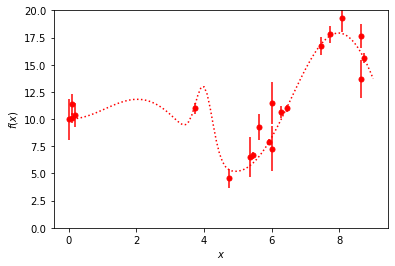

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as k

# Create the noisy data
Nrandom = 20

def f(x):
    '''function to model'''
    h = 6.*np.exp(-0.5 * ((x - 4.) / 0.25) ** 2) + x * np.sin(x) + 10.
    return h

# points to evaluate the model
x_model = np.linspace(0,9,100)
y_model = f(x_model)

#select a subset of these points
x = x_model[np.sort(np.random.randint (0, 100, Nrandom))]
y_true = f(x)
dy = 0.2 + 1.9 * np.random.random(y_true.shape)
noise = np.random.normal(0, dy*np.ones(Nrandom))
y = y_true + noise

plt.figure()
plt.plot(x_model, y_model, 'r:')
plt.errorbar(x, y, dy, fmt='r.', markersize=10, label=u'Observations')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 20)

Using scikit-learn we can apply a GP to these data (initially noise free). First we define the Kernel (see sklearn.gaussian_process.kernels). For this can use a radial basis function (equivalent to the squared exponential) and we learn the hyperparameters from the data.

Optimized hyper parameters:  8.81**2 * RBF(length_scale=1.17)


(0.0, 20.0)

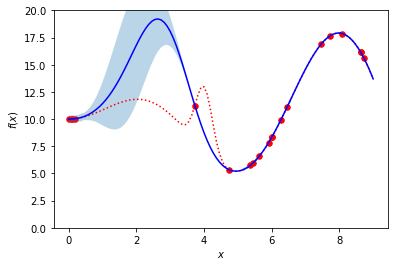

In [3]:
# define a kernel - squared exponential, normalized by variance, 
kernel = np.var(y)*k.RBF(length_scale=10.0)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=90)
gp.fit(np.atleast_2d(x).T, y_true)
print("Optimized hyper parameters: ", gp.kernel_)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x_model[:,None], return_std=True)

plt.figure()
plt.plot(x_model, y_model, 'r:')
plt.scatter(x, y_true, c='r', s=30)
#plt.errorbar(x, y, dy, fmt='r.', markersize=10, label=u'Observations')
plt.plot(x_model, y_pred, 'b-', label=u'Prediction')

plt.fill_between(
    x_model,
    y_pred - 1.96 * sigma,
    y_pred + 1.96 * sigma,
    alpha=0.3,
    label=r"95% confidence interval",
)

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 20)

Now we will repeat the exercise including the noise

Optimized hyper parameters:  11.9**2 * RBF(length_scale=2.18)


(0.0, 20.0)

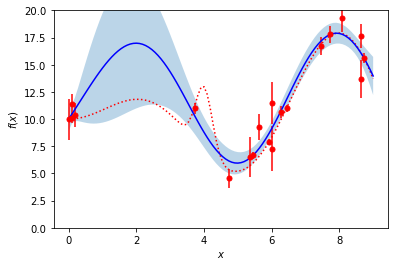

In [4]:
kernel = np.var(y)*k.RBF(length_scale=20.0)

gp = GaussianProcessRegressor(
    kernel=kernel, alpha=0.9**2, n_restarts_optimizer=90
)
gp.fit(np.atleast_2d(x).T, y)
print("Optimized hyper parameters: ", gp.kernel_)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x_model[:,None], return_std=True)

plt.figure()
plt.plot(x_model, y_model, 'r:')
plt.errorbar(x, y, dy, fmt='r.', markersize=10, label=u'Observations')
plt.plot(x_model, y_pred, 'b-', label=u'Prediction')

plt.fill_between(
    x_model,
    y_pred - 1.96 * sigma,
    y_pred + 1.96 * sigma,
    alpha=0.3,
    label=r"95% confidence interval",
)

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 20)

To see what is happening with the fitting we can plot the prior and posterior of a GaussianProcessRegressor  (see [scikit-learn](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-prior-posterior-py))

In [5]:
def plot_gpr_samples(gpr_model, n_samples, ax):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    x = np.linspace(0, 9, 100)
    X = x.reshape(-1, 1)

    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")

Text(0.5, 1.0, 'Samples from posterior distribution')

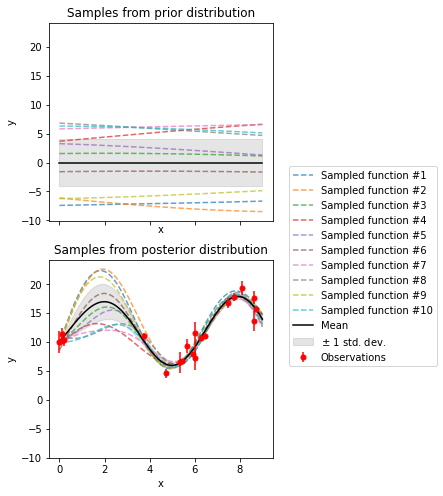

In [6]:
#define the kernel and the GaussianProcessRegressor
kernel = np.var(y)*k.RBF(length_scale=20.0)

gp = GaussianProcessRegressor(
    kernel=kernel, alpha=0.9**2, n_restarts_optimizer=90
)

fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(4, 8))

# plot the prior
n_samples=10
plot_gpr_samples(gp, n_samples=n_samples, ax=axs[0])
axs[0].set_title("Samples from prior distribution")

# plot the posterior
gp.fit(np.atleast_2d(x).T, y)
plot_gpr_samples(gp, n_samples=n_samples, ax=axs[1])
axs[1].errorbar(x, y, dy, fmt='r.', markersize=10, label=u'Observations')
axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

This time we will use [George](http://dfm.io/george/dev/) which is "designed to be used alongside your favorite non-linear optimization or posterior inference library for the best results."

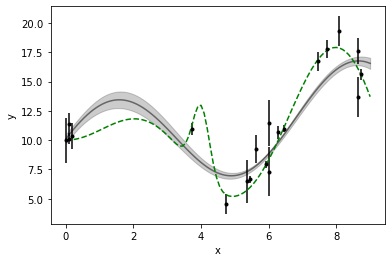

In [7]:
import numpy as np
import george
from george import kernels

kernel = np.var(y) * kernels.ExpSquaredKernel(10.)
gp = george.GP(kernel)
gp.compute(x, dy)

pred, pred_var = gp.predict(y, x_model, return_var=True)

plt.fill_between(x_model, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_model, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(x, y, yerr=dy, fmt=".k", capsize=0)
plt.plot(x_model, y_model, "--g")

plt.xlabel("x")
plt.ylabel("y");

In [ ]:
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(y, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(x, dy)
print ("Parameters prior to optimization: ", gp.get_parameter_vector())

# Print the initial ln-likelihood.
print("Log-likelihood prior to optimization: ", gp.log_likelihood(y))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")
print ("Parameters after  optimization: ", results.x)

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print("Log-likelihood after to optimization: ", gp.log_likelihood(y))

In [ ]:
pred, pred_var = gp.predict(y, x_model, return_var=True)

plt.fill_between(x_model, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_model, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(x, y, yerr=dy, fmt=".k", capsize=0)
plt.plot(x_model, y_model, "--g")

plt.xlabel("x")
plt.ylabel("y");

### Building more complex models and kernels <a id='complex'></a>
[Go to top](#toc)

We can build complex kernels based on the properties of the data. Here we take a classic case from the original Rasmussen and Williams book; modeling the monthly average atmospheric CO2 concentrations (in parts per million by volume (ppmv)) collected at the Mauna Loa Observatory (1958 to 1997). 

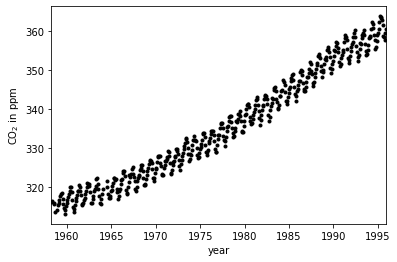

In [8]:
from statsmodels.datasets import co2

data = co2.load_pandas().data
t = 2000 + (np.array(data.index.to_julian_date()) - 2451545.0) / 365.25
y = np.array(data.co2)
m = np.isfinite(t) & np.isfinite(y) & (t < 1996)
t, y = t[m][::4], y[m][::4]

plt.plot(t, y, ".k")
plt.xlim(t.min(), t.max())
plt.xlabel("year")
plt.ylabel("CO$_2$ in ppm");

#### Exercise: we want to model  the CO2 concentration as a function of time. To do this we need to account for 
- a long term increase in the CO2 concentrate. A RBF kernel (RBF: scikit-learn, ExpSquaredKernel: George) can account for this sort of trend
- a periodic or seasonal variation. A periodic kernel (ExpSineSquared: scikit-learn,  ExpSine2Kernel: George)  can capture this if we set the period
- medium scale irregularities. These can be explained by a rational quadratic kernel (RationalQuadratic: scikit-learn,  RationalQuadraticKernel: George) 
- a noise term. This can be captured by a whitening term (WhiteKernel: scikit-learn,  ExpSquaredKernel: George) 

1. Build a kernel to explain the long term growth in CO2 with time and plot the model over the data points.
2. Add in a kernel that can account for the periodic signal. You can sum individual kernel components (e.g. kernel = k.RBF() + k.WhiteKernel()). Show how well you can model the data. You will need to think about the parameters that you should set for the kernels. Start with just a one or two component kernel before advancing to the full model 
3. Subsample the data and re-estimate the kernels for the data (data_subset = co2.load_pandas().data.sample(200))

Use scikit-learn, or George, or any other GP package.